# Dimensionality Reduction: LDA Multi Cluster

### K>2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
iris_df= pd.read_csv("iris.data", names=['sepal length','sepal width','petal length','petal width','target'])
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']

X = iris_df.loc[:, features].values

#encoding the y(target column) 
from sklearn.preprocessing import LabelEncoder
y = iris_df.loc[:,['target']].values
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y)+1 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Calculating mean vectors for each class

In [4]:

mean_vec=[]
class_dict={1: 'Iris-setosa', 2: 'Iris-versicolor', 3:'Iris-virginica' }
for cl in range(len(class_dict)):
    mean_vec.append(np.mean(X[y==cl+1], axis=0))
    print(f'Mean Class {cl+1}: {mean_vec[cl]}')

Mean Class 1: [5.006 3.418 1.464 0.244]
Mean Class 2: [5.936 2.77  4.26  1.326]
Mean Class 3: [6.588 2.974 5.552 2.026]


### Calculating SW (with-in class scatter matrix)

In [5]:
# calculating within class scatter matrix SW

n_f=X.shape[1]
S_W = np.zeros((n_f,n_f))
for cl,mv in enumerate(mean_vec):
    class_sc_mat = np.zeros((n_f,n_f))                  # scatter matrix for every class
    for row in X[y == cl+1]:
        row, mv = row.reshape(n_f,1), mv.reshape(n_f,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


### Calculating SB (between-class scattter matrix)

In [6]:
#calculating within class scatter matrix SB

overall_mean=np.mean(X, axis=0)
S_B = np.zeros((n_f,n_f))
for i,mv in enumerate(mean_vec):  
    n = X[y==i+1,:].shape[0]
    mv = mv.reshape(n_f,1) # make column vector
    overall_mean = overall_mean.reshape(n_f,1) # make column vector
    S_B += n * (mv - overall_mean).dot((mv - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.21213333 -19.534      165.16466667  71.36306667]
 [-19.534       10.9776     -56.0552     -22.4924    ]
 [165.16466667 -56.0552     436.64373333 186.90813333]
 [ 71.36306667 -22.4924     186.90813333  80.60413333]]


### Computing the LDA projection

In [7]:
S_W_inv=np.linalg.inv(S_W)
dot=np.dot(S_W_inv, S_B)
eigval, eigvec= np.linalg.eig(dot)
print(np.round(eigval, 3), '\n')
print(np.round(eigvec, 3))

[32.272  0.278 -0.     0.   ] 

[[ 0.205 -0.009 -0.637  0.295]
 [ 0.387 -0.589 -0.023 -0.416]
 [-0.546  0.254 -0.09  -0.473]
 [-0.714 -0.767  0.765  0.718]]


### Calculate eigenvalue, eigenvector

In [8]:
# Make a list of (eigenvalue, eigenvector) tuples and sort them in decreasing order
eig_pairs = [(np.abs(eigval[i]), eigvec[:,i]) for i in range(len(eigval))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

for i in eig_pairs:
    print(i[0])
    print(np.around(i[1], 3), '\n')

32.271957799729805
[ 0.205  0.387 -0.546 -0.714] 

0.2775668638400484
[-0.009 -0.589  0.254 -0.767] 

5.010867534969835e-15
[ 0.295 -0.416 -0.473  0.718] 

3.9051190268434875e-15
[-0.637 -0.023 -0.09   0.765] 



In order to choose top K eigenvector we look at variance explained <br/>
The result show that first eigenvector explains 99% and if we reduce to 1d we don't lose much info<br/>
As second one also has a non-zero variance, we can choose 2 dimensions 

In [9]:
print('Variance Explained:\n')
eigval_sum = sum(eigval)
for i,j in enumerate(eig_pairs):
    var_exp=(j[0]/eigval_sum)
    print(f'eigenvalue {i+1}: {np.round(var_exp*100, 2)}%')

Variance Explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.0%
eigenvalue 4: 0.0%


### Calculate W

In [10]:
W = np.hstack((eig_pairs[0][1].reshape(n_f,1), eig_pairs[1][1].reshape(n_f,1)))
W

array([[ 0.20490976, -0.00898234],
       [ 0.38714331, -0.58899857],
       [-0.54648218,  0.25428655],
       [-0.71378517, -0.76703217]])

### Project dataset in dimensions

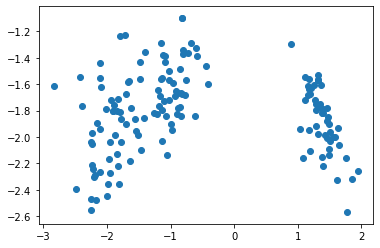

In [11]:
Z=[]
for x in X:
    Z.append(np.dot(W.T, x))
Z_df=pd.DataFrame(data=Z, columns=['LDA1', 'LDA2'])
plt.scatter(Z_df['LDA1'], Z_df['LDA2']) ; 